In [1]:
from tqdm import tqdm
from time import time
from tqdm import trange

import matplotlib.pyplot as plt
import numpy as np
import scipy

import jax
import jax.flatten_util as flatten_util
import jax.numpy as jnp

from flax import linen as nn

from typing import NamedTuple

In [2]:
seed = 0

In [3]:
class SpringState(NamedTuple):
    phi: jnp.ndarray
    buffer: jnp.ndarray
    buffer_index: jnp.ndarray
    r_hat: float
    beta: float
    checkpoint_idx: int

In [4]:
class SpringCleanState(NamedTuple):
    phi: jnp.ndarray

In [5]:
class ResNet(nn.Module):
    """A simple ResNet model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=50)(jnp.sin(2 * jnp.pi * x))
        x = nn.tanh(x)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        x = nn.Dense(features=1)(x)
        return x


model_fn = ResNet()

In [6]:
def scalar_model_fn(params, batch):
    return model_fn.apply(params, batch)[0]


model_grad = jax.value_and_grad(scalar_model_fn, argnums=0)


def raveled_grad_fn(params, batch):
    value, grad = model_grad(params, batch)
    return value, flatten_util.ravel_pytree(grad)[0]


jacobian_fn = jax.jit(jax.vmap(raveled_grad_fn, in_axes=(None, 0), out_axes=(0, 0)))

In [7]:
key = jax.random.PRNGKey(seed)
ord = 15 #Change to make more ill conditioned

coeff = jax.random.normal(key, shape=(ord,))
poly = np.polynomial.chebyshev.Chebyshev(coeff)

def target_fn(x):
    return poly(jnp.sin(2 * jnp.pi * x)) / np.sqrt(ord)

Text(0, 0.5, 'f(s)')

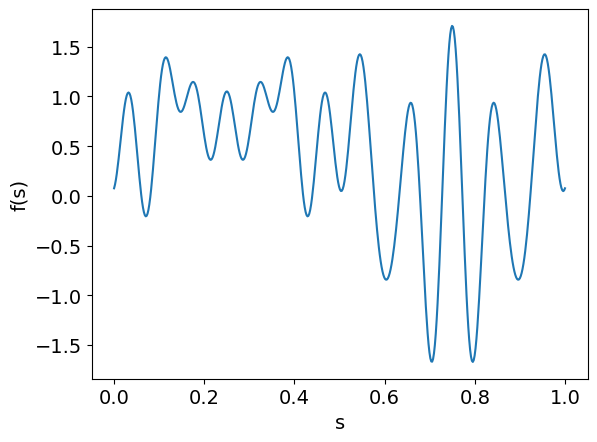

In [8]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

xs = np.linspace(0,1,500)
plt.plot(xs, target_fn(xs))
plt.xlabel("s")
plt.ylabel("f(s)")
#plt.savefig("NN_target_fn.pdf", bbox_inches='tight')

In [9]:
def loss_fn(model_params, xs):
    """Mean-squared error loss"""
    predictions = model_fn.apply(model_params, xs)
    targets = target_fn(xs)

    return jnp.mean((predictions - targets) ** 2)


loss_fn = jax.jit(loss_fn)
loss_fn_grad = jax.jit(jax.value_and_grad(loss_fn, argnums=0))

In [10]:
rng = jax.random.PRNGKey(seed)

rng, key = jax.random.split(rng)
dummy_x = jax.random.uniform(key, shape=(100, 1))

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
param_vec, unravel_fn = flatten_util.ravel_pytree(params)

initial_params = params

print(f"nparams: {jax.flatten_util.ravel_pytree(params)[0].shape[0]}")

nparams: 7801


## Kaczmarz Algorithm (Without adaptive acceleration)

In [11]:
def get_NGD_optimizer(params, rng, dummy_x, alpha, lamb):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    opt_state = []

    def step(params, batch, targets, opt_state, rng):
        batch_size = batch.shape[0]

        predictions, jacobian = jacobian_fn(params, batch)
        residuals = (targets - predictions)

        loss = jnp.sum(residuals**2) / batch_size

        jacobian /= jnp.sqrt(batch_size)
        residuals /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)

        ravel_update = jacobian.T @ jax.scipy.linalg.solve(T, residuals, assume_a="pos")

        update = unravel_fn(ravel_update)
        params = jax.tree.map(lambda p, u: p + alpha * u, params, update)

        return params, [], rng, loss, None

    return opt_state, jax.jit(step), rng

In [13]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
alpha = 0.5 #learning rate, 
num_it = 500

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_NGD_optimizer(params, rng, dummy_x, alpha, lamb)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

Loss 4.310e-06: 100%|██████████| 500/500 [05:02<00:00,  1.65its/s]


Text(0, 0.5, 'Loss estimate')

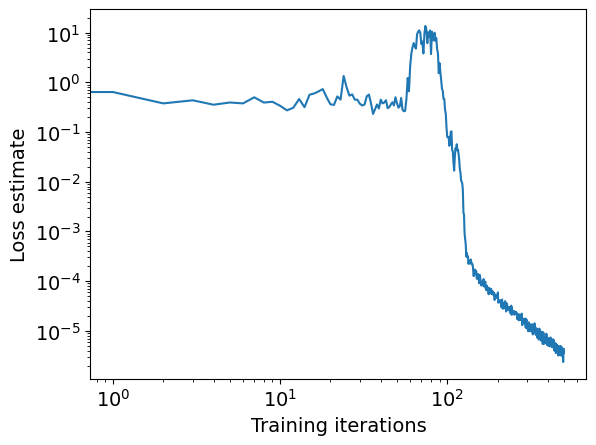

In [14]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## Kaczmarz++ Algorithm

In [12]:
def get_kaczmarzpp_optimizer(params, rng, dummy_x, alpha, eta, lamb, p, accelerated=True):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    opt_state = []
    mtm = jnp.zeros_like(param_vec)

    # Momentum update parameters
    rho = 0.0
    mtm_param = 0.0 if not accelerated else (1 - rho) / (1 + rho)
    r_hat = 1.0
    checkpoint_idx = 1

    residuals = []

    def step(params, batch, targets, opt_state, rng, step_idx):
        nonlocal mtm, rho, r_hat, checkpoint_idx, mtm_param, alpha, residuals

        batch_size = batch.shape[0]

        predictions, jacobian = jacobian_fn(params, batch)
        residual = (targets - predictions)

        # Save normalized residual for adaptive momentum
        res_norm = jnp.linalg.norm(residual) / jnp.linalg.norm(targets)
        residuals.append(res_norm)

        loss = jnp.sum(residual**2) / batch_size
        
        jacobian /= jnp.sqrt(batch_size)
        residual /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)
        ravel_update = jacobian.T @ jax.scipy.linalg.solve(T, residual, assume_a="pos") # Equivalent to finding w

        # Apply momentum and update
        if not accelerated:
            ravel_step = ravel_update
        else:
            mtm = mtm_param * (mtm - ravel_update)
            ravel_step = ravel_update + eta * mtm

        update = unravel_fn(ravel_step)
        params = jax.tree.map(lambda p, u: p + alpha * u, params, update)

        # Every p steps, update rho and mtm_param adaptively
        if accelerated and step_idx % p == 0 and step_idx >= 2 * p:
            eps_t = jnp.sum(jnp.array(residuals[step_idx - p:step_idx]) ** 2)
            eps_tp = jnp.sum(jnp.array(residuals[step_idx - 2*p:step_idx - p]) ** 2)
            r_ip = eps_t / eps_tp

            a_new = (checkpoint_idx + 1) ** jnp.log(checkpoint_idx + 1)
            a_old = checkpoint_idx ** jnp.log(checkpoint_idx)
            alph = a_old / a_new

            r_hat = alph * r_hat + (1 - alph) * jnp.minimum(1.0, r_ip)
            rho = jnp.maximum(0.0, 1 - r_hat ** (1 / p))
            mtm_param = (1 - rho) / (1 + rho)
            checkpoint_idx += 1

        return params, [], rng, loss, None

    return opt_state, jax.jit(step), rng

In [16]:
rng = jax.random.PRNGKey(seed)

alpha = 0.5 # Learning rate
eta = 0.5 # Momentum strength
lamb = 1e-2 # Regularization parameter
p = 10 # Lookback window for adaptive momentum
accelerated = False

num_it = 500

# Initialize model parameters and data
rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

# Initialize Kaczmarz++ optimizer
opt_state, opt_step, rng = get_kaczmarzpp_optimizer(params, rng, dummy_x, alpha, eta, lamb, p, accelerated)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

Loss 4.310e-06: 100%|██████████| 500/500 [04:30<00:00,  1.85its/s]


Text(0, 0.5, 'Loss estimate')

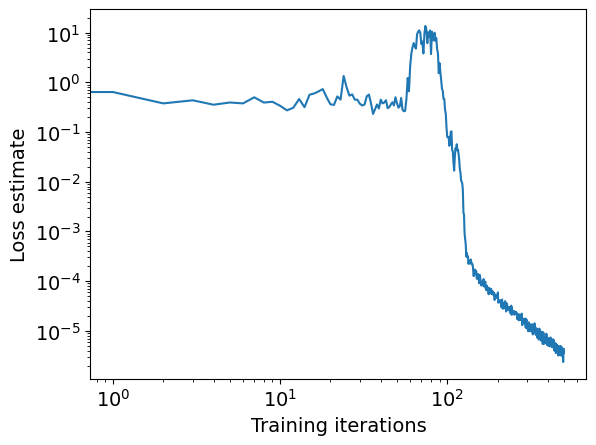

In [17]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## SPRING (clean)

In [13]:
def get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb):    
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    phi = jnp.zeros_like(param_vec)
    opt_state = SpringCleanState(phi)
    
    def step(params, batch, targets, opt_state, rng):
        phi = opt_state.phi
    
        batch_size = batch.shape[0]
        predictions, jacobian = jacobian_fn(params, batch)
        residual = targets - predictions

        loss = jnp.sum(residual ** 2) / batch_size

        correction = residual - jacobian @ (beta * phi)

        jacobian /= jnp.sqrt(batch_size)
        correction /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)
        delta_phi = jacobian.T @ jax.scipy.linalg.solve(T, correction, assume_a="pos")
        
        phi = beta * phi + delta_phi

        update = unravel_fn(phi)        
        params = jax.tree.map(lambda p, u: p + eta * u, params, update)

        opt_state = SpringCleanState(phi)
        
        return params, opt_state, rng, loss, None

    return opt_state, jax.jit(step), rng

In [19]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
eta = 0.5 #learning rate 
beta = 0

num_it = 500

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

loss_list_clean = loss_list

Loss 3.338e-06: 100%|██████████| 500/500 [05:53<00:00,  1.42its/s]


Text(0, 0.5, 'Loss estimate')

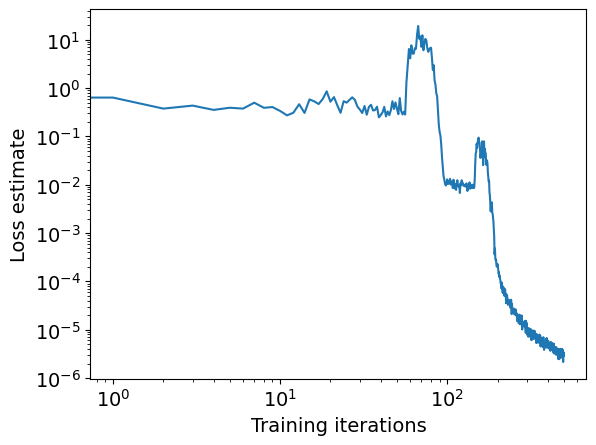

In [20]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## SPRING (Adaptive momentum)

In [14]:
def get_spring_optimizer(params, rng, dummy_x, eta, lamb, p):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    phi = jnp.zeros_like(param_vec)
    buffer = jnp.zeros(2 * p)
    buffer_index = jnp.array(0)
    r_hat = 1.0
    beta = 0.9
    checkpoint_idx = 1
    
    opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
    
    def step(params, batch, targets, opt_state, rng, step_idx):
        phi, buffer, buffer_index, r_hat, beta, checkpoint_idx = opt_state

        batch_size = batch.shape[0]
        
        predictions, jacobian = jacobian_fn(params, batch)
        residual = targets - predictions

        # Save normalized residual for adaptive momentum
        res_norm = jnp.linalg.norm(residual) / jnp.linalg.norm(targets)
        buffer = buffer.at[buffer_index % (2 * p)].set(res_norm)
        buffer_index += 1        
        
        loss = jnp.sum(residual ** 2) / batch_size

        # Correction term: r - J @ (beta * phi)
        correction = residual - jacobian @ (beta * phi) # Residual and jacobian, and phi are all not normalized
        
        jacobian /= jnp.sqrt(batch_size)
        correction /= jnp.sqrt(batch_size)
        

        # Least-squares solve: minimize || J φ - correction ||^2
        # Solution: phi = beta * phi + J.T @ ( (J J.T)^-1 @ correction )
        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size) 
        delta_phi = jacobian.T @ jax.scipy.linalg.solve(T, correction, assume_a="pos") 
        phi = beta * phi + delta_phi

        # Parameter update
        update = unravel_fn(phi)
        params = jax.tree.map(lambda p, u: p + eta * u, params, update)

        #update beta
        def update_beta(step_idx, beta, r_hat, checkpoint_idx):
            def update_beta_fn(args):
                buffer, beta, r_hat, checkpoint_idx, buffer_index = args
                idxs_t = (buffer_index - jnp.arange(1, p + 1)) % (2 * p)
                idxs_tp = (buffer_index - jnp.arange(p + 1, 2 * p + 1)) % (2 * p)
                eps_t = jnp.sum(buffer[idxs_t] ** 2)
                eps_tp = jnp.sum(buffer[idxs_tp] ** 2)
                r_ip = eps_t / eps_tp
    
                a_new = (checkpoint_idx + 1) ** jnp.log(checkpoint_idx + 1)
                a_old = checkpoint_idx ** jnp.log(checkpoint_idx)
                alph = a_old / a_new
    
                r_hat_new = alph * r_hat + (1 - alph) * jnp.minimum(1.0, r_ip)
                rho = jnp.maximum(0.0, 1 - r_hat_new ** (1 / p))
                beta_new = (1 - rho) / (1 + rho)
                return beta_new, r_hat_new, checkpoint_idx + 1, rho

            def skip_update(args):
                _, beta, r_hat, checkpoint_idx, _ = args
                return beta, r_hat, checkpoint_idx, jnp.nan
    
            cond = jnp.logical_and(step_idx % p == 0, step_idx >= 2 * p)
            beta, r_hat, checkpoint_idx, rho = jax.lax.cond(
            cond, update_beta_fn, skip_update,
            operand=(buffer, beta, r_hat, checkpoint_idx, buffer_index)
        )

        opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
        return params, opt_state, rng, loss, None
            
    return opt_state, jax.jit(step), rng

In [22]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
eta = 0.5 #learning rate 
p = 10

num_it = 500

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_spring_optimizer(params, rng, dummy_x, eta, lamb, p)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

loss_list_aa = loss_list

Loss 6.523e-07: 100%|██████████| 500/500 [05:46<00:00,  1.44its/s]


Text(0, 0.5, 'Loss estimate')

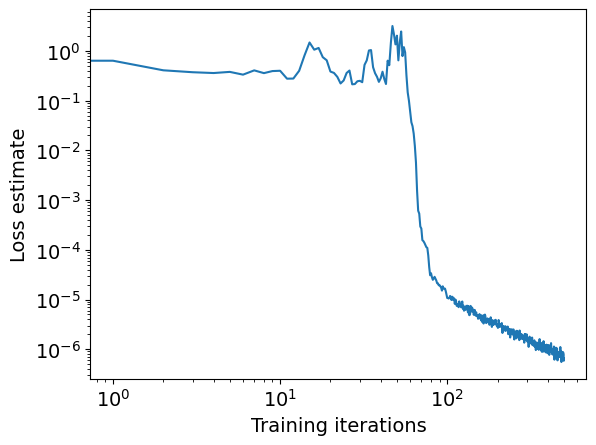

In [23]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## minSR (SPRING w/ beta = 0) VS SPRING (Adaptive Momentum)

In [16]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.figure(figsize=(8, 5))
plt.plot(loss_list_clean, label="SPRING (no momentum)")
plt.plot(loss_list_aa, label="SPRING (adaptive momentum)", linestyle="--")

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.legend()
plt.grid(True)
plt.title("Comparison of SPRING Variants")

# Optional: save to file
# plt.savefig("SPRING_comparison.pdf", bbox_inches="tight")
plt.show()

NameError: name 'loss_list_clean' is not defined

<Figure size 800x500 with 0 Axes>

## Comparing minSR and SPRING across eta values

In [ ]:
eta_vals = [0.1, 0.3, 0.5, 0.7]
num_it = 1000
lamb = 1e-2
p = 10
batch_size = 500

minSR_losses = []
spring_adaptive_losses = []

for eta in eta_vals:
    print(f"minSR vs SPRING adaptive for eta = {eta}")
    
    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # minSR
    params_clean = params
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params_clean, rng, dummy_x, eta, beta=0, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params_clean, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params_clean, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    minSR_losses.append(loss_list_clean)

    # SPRING adaptive
    params_adaptive = params
    loss_list_adaptive = []
    opt_state_adaptive, opt_step_adaptive, rng_adaptive = get_spring_optimizer(params_adaptive, rng, dummy_x, eta, lamb, p)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_adaptive, key = jax.random.split(rng_adaptive)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params_adaptive, opt_state_adaptive, rng_adaptive, loss, _ = opt_step_adaptive(params_adaptive, batch, targets, opt_state_adaptive, rng_adaptive, i)
            loss_list_adaptive.append(loss)

    spring_adaptive_losses.append(loss_list_adaptive)

minSR vs SPRING adaptive for eta = 0.1


100%|██████████| 1000/1000 [12:24<00:00,  1.34its/s]


minSR vs SPRING adaptive for eta = 0.3


100%|██████████| 1000/1000 [12:26<00:00,  1.34its/s]


minSR vs SPRING adaptive for eta = 0.5


 36%|███▌      | 357/1000 [04:29<10:22,  1.03its/s]

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(16, 10))

for idx, eta in enumerate(eta_vals):
    plt.subplot(2, 2, idx + 1)
    plt.plot(minSR_losses[idx], label="MinSR")
    plt.plot(spring_adaptive_losses[idx], label="SPRING (adaptive)", linestyle="--")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(f"η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("MinSR and SPRING Comparison for Different η", y=1.02, fontsize=16)
# plt.savefig("spring_eta_comparison.pdf", bbox_inches="tight")
plt.show()

## Comparing best eta vs best eta

### Finding best eta for minSR

In [ ]:
eta_vals = [0.1, 0.3, 0.5, 0.7]
num_it = 1000
lamb = 1e-2
batch_size = 500

minSR_losses = []

for eta in eta_vals:
    print(f"minSR for eta value {eta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # minSR
    params_clean = params
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params_clean, rng, dummy_x, eta, beta=0, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params_clean, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params_clean, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    minSR_losses.append(loss_list_clean)


minSR for eta value 0.1


100%|██████████| 1000/1000 [11:23<00:00,  1.46its/s]


minSR for eta value 0.3


100%|██████████| 1000/1000 [11:12<00:00,  1.49its/s]


minSR for eta value 0.5


 42%|████▏     | 423/1000 [04:47<06:38,  1.45its/s]

In [ ]:
plt.figure(figsize=(8, 5))
for i, eta in enumerate(eta_vals):
    plt.plot(minSR_losses[i], label=f"η = {eta}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.title("minSR across η values")
plt.legend()
plt.grid(True)
# Optional: plt.savefig("minSR_eta_comparison.pdf", bbox_inches="tight")
plt.show()

### Finding best eta for SPRING

In [ ]:
eta_vals = [0.1, 0.3, 0.5, 0.6, 0.7]
num_it = 1000
lamb = 1e-2
batch_size = 500

spring_adaptive_losses = []

for eta in eta_vals:
    print(f"SPRING for eta value {eta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # SPRING adaptive
    params_adaptive = params
    loss_list_adaptive = []
    opt_state_adaptive, opt_step_adaptive, rng_adaptive = get_spring_optimizer(params_adaptive, rng, dummy_x, eta, lamb, p)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_adaptive, key = jax.random.split(rng_adaptive)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params_adaptive, opt_state_adaptive, rng_adaptive, loss, _ = opt_step_adaptive(params_adaptive, batch, targets, opt_state_adaptive, rng_adaptive, i)
            loss_list_adaptive.append(loss)

    spring_adaptive_losses.append(loss_list_adaptive)


In [ ]:
plt.figure(figsize=(8, 5))
for i, eta in enumerate(eta_vals):
    plt.plot(spring_adaptive_losses[i], label=f"η = {eta}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.title("SRPING across η values")
plt.legend()
plt.grid(True)
# Optional: plt.savefig("minSR_eta_comparison.pdf", bbox_inches="tight")
plt.show()

### best eta vs best eta

In [ ]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
minSR_eta = 0.5 #learning rate 
beta = 0

num_it = 500

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_spring_optimizer_clean(params, rng, dummy_x, minSR_eta, beta, lamb)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

loss_list_clean = loss_list

In [ ]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
spring_eta =  0.5 #learning rate 
p = 10

num_it = 500

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_spring_optimizer(params, rng, dummy_x, spring_eta, lamb, p)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

loss_list_aa = loss_list

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.figure(figsize=(8, 5))
plt.plot(loss_list_clean, label=f"MinSR (eta = {minSR_eta}, lambda = 1e-2)")
plt.plot(loss_list_aa, label=f"Adaptive SPRING (eta = {spring_eta}, lambda = 1e-2)", linestyle="--")

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.legend()
plt.grid(True)
plt.title("MinSR vs Adaptive SPRING with Tuned η")

# Optional: save to file
# plt.savefig("SPRING_comparison.pdf", bbox_inches="tight")
plt.show()

## Testing whether adaptive beta is the best

In [ ]:
#beta_vals = [0.87, 0.86, 0.85, 0.84]
beta_vals = [0.86, 0.855, 0.85]
num_it = 3000
lamb = 1e-2
batch_size = 500
eta = 0.5

spring_losses = []

for beta in beta_vals:
    print(f"SPRING for beta value {beta}")

    # Re-initialize parameters for a fair comparison
    rng = jax.random.PRNGKey(seed)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)

    # SPRING
    loss_list_clean = []
    opt_state_clean, opt_step_clean, rng_clean = get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb=lamb)

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng_clean, key = jax.random.split(rng_clean)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state_clean, rng_clean, loss, _ = opt_step_clean(params, batch, targets, opt_state_clean, rng_clean)
            loss_list_clean.append(loss)

    spring_losses.append(loss_list_clean)

In [ ]:
# SPRING adaptive
num_it = 3000
lamb = 1e-2
batch_size = 500
eta = 0.5
p = 10 

rng = jax.random.PRNGKey(seed)
rng, key = jax.random.split(rng)
params_adaptive = model_fn.init(key, dummy_x)

loss_list_adaptive = []
opt_state_adaptive, opt_step_adaptive, rng_adaptive = get_spring_optimizer(params_adaptive, rng, dummy_x, eta, lamb, p)

with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng_adaptive, key = jax.random.split(rng_adaptive)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]
        params_adaptive, opt_state_adaptive, rng_adaptive, loss, _ = opt_step_adaptive(params_adaptive, batch, targets, opt_state_adaptive, rng_adaptive, i)
        loss_list_adaptive.append(loss)

In [ ]:
spring_losses.append(loss_list_adaptive)

In [ ]:
plt.figure(figsize=(8, 5))
for i, beta in enumerate(beta_vals):
    plt.plot(spring_losses[i], label=f"beta value = {beta}, lambda = {lamb}, eta = {eta}")
plt.plot(spring_losses[-1], label=f"beta value = adaptive, lambda = {lamb}, eta = {eta}")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.title("SPRING Optimizer: Fixed vs Adaptive β")
plt.legend()
plt.grid(True)
# Optional: plt.savefig("spring_beta_comparison.pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(spring_losses[0], label=f"beta value = {beta_vals[0]}, lambda = {lamb}, eta = {eta}")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.title("SPRING Optimizer: Fixed vs Adaptive β")
plt.legend()
plt.grid(True)
# Optional: plt.savefig("spring_beta_comparison.pdf", bbox_inches="tight")
plt.show()